
<hr>

## <h3 align="center"> Equancy Test technique <h3/>

<p>





# Détermination du métier d’un candidat



## Objectif du Projet
L’objectif de cet exercice est de déterminer le métier d’un candidat à partir des informations sur ses compétences.
A partir d'un dataset de compétences, nous réaliserons:
- Un clustering non supervisé afin d'identifier les groupes de profils techniques distincts
- Une prédiction des profils dont le métier n'est pas labellisé


## Étapes du Notebook
1. Importation des bibliothèques
2. Chargement des données
3. Exploration des données
    - 3.1 Analyse univariée de la variable dépendante
    - 3.2 Analyse comparative du métier selon le diplôme
4. Prétraitement des données
    - 4.1 Expérience moyenne par métier
    - 4.2 Catégorisation de la variable Experience
    - 4.3 Analyse comparative du métier selon la catégorie d'expérience
    - 4.4 Identification du top 5 des technologies    
5. Clustering : classification non supervisée
6. Prédiction des métiers manquants dans la base de données par Random Forest
    - 6.1 Construction du modèle
    - 6.2 Évaluation du modèle
    - 6.3 Prédiction des métiers manquants





## 1- Importation des bibliothèques

In [1]:
!pip install kmodes
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve,auc,classification_report,accuracy_score,confusion_matrix,f1_score
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from kmodes.kmodes import KModes

## 2- Chargement des données

In [2]:
df = pd.read_csv("data.csv")
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


## 3- Exploration des données

In [3]:
df.shape

(9582, 6)

In [4]:
df.columns

Index(['Entreprise', 'Metier', 'Technologies', 'Diplome', 'Experience',
       'Ville'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Entreprise    9565 non-null   object
 1   Metier        9563 non-null   object
 2   Technologies  9582 non-null   object
 3   Diplome       9582 non-null   object
 4   Experience    9488 non-null   object
 5   Ville         9582 non-null   object
dtypes: object(6)
memory usage: 449.3+ KB


In [6]:
print("Nan in each columns:" , df.isna().sum(), sep='\n')

Nan in each columns:
Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64


- The dataset has information about 9852 applicants.
- We have 6 variables including 5 independent variables and 1 dependent variable which is Metier.
- The dataset contains missing values.
- We have 5 categorical variables: 'Entreprise', 'Metier', 'Technologies', 'Diplome',  'Ville'
- We have 1 numeric variables: 'Experience'

#### 3-1 Analyse univariée de la variable dépendante

In [7]:
df.Metier.describe()

count               9563
unique                 4
top       Data scientist
freq                3865
Name: Metier, dtype: object

In [8]:
metier_df = df.Metier.value_counts().reset_index()

# Renommer les colonnes pour plus de clarté
metier_df.columns = ['Metier','Nombre de candidats']

# Afficher la DataFrame
metier_df

,Metier,Nombre de candidats
0,Data scientist,3865
1,Data engineer,2347
2,Data architecte,2123
3,Lead data scientist,1228


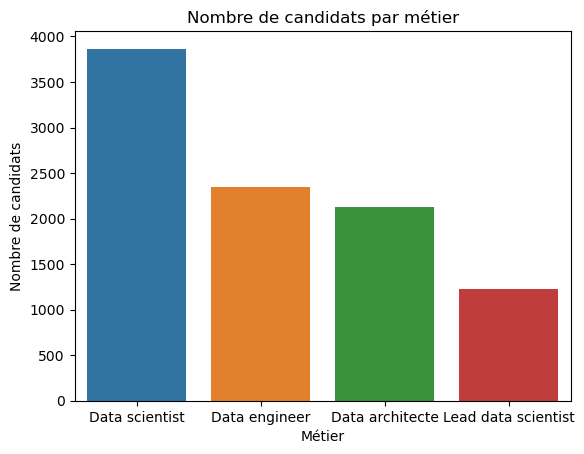

In [9]:
# Création d'un graphique à barre avec Seaborn
sns.barplot(data= metier_df, x='Metier', y= 'Nombre de candidats' )

# Ajout d'etiquettes et de titre
plt.title('Nombre de candidats par métier')
plt.ylabel('Nombre de candidats')
plt.xlabel('Métier')

# Afficher le graphique
plt.show()

#### 3-2 Analyse comparative du métier selon le diplome

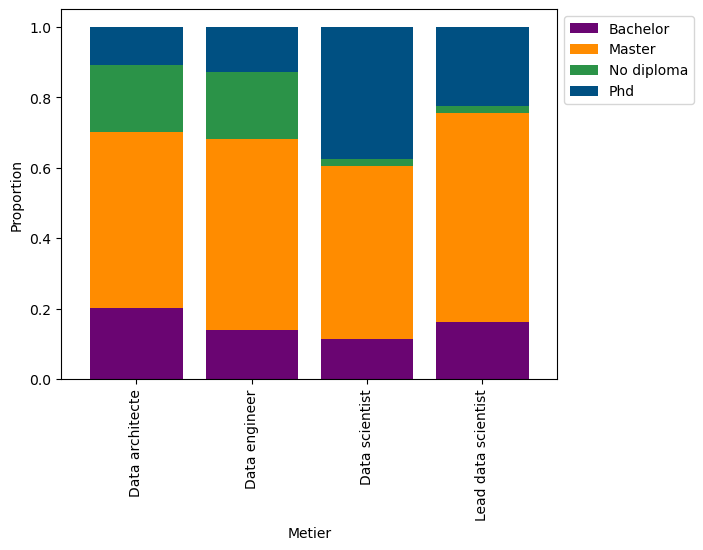

In [10]:
cross_tab_prop_dip = pd.crosstab(index=df['Metier'], columns=df['Diplome'], normalize='index')

# Définir une liste de quatre couleurs qui vont bien ensemble
colors = ['#6a0572', '#ff8c00', '#2b9348', '#005082']

# Créer une colormap à partir de la liste de couleurs
custom_cmap = ListedColormap(colors)

ax = cross_tab_prop_dip.plot(kind='bar', stacked=True, width=0.8,  cmap= custom_cmap,
                        legend=False, ylabel='Proportion', sharey=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))


La colonne Expérience présente actuellement des valeurs de type 'object' et utilise des virgules pour représenter les nombres décimaux, ce qui n'est pas conforme à la convention utilisée par Python (qui reconnait les nombres décimaux avec les points). Pour résoudre cette situation, il est nécessaire d'effectuer les opérations suivantes: remplacer toutes les virgules par des points dans la colonne Experience et ensuite convertir les valeurs de la colonne du type 'string' vers le type 'float' pour assurer la cohérence des données.

## 4. Prétraitement des données

In [11]:
# Convertir la colonne en float en remplaçant les virgules par des points
df['Experience'] = df['Experience'].apply(lambda x: float(str(x).replace(',', '.')) if pd.notnull(x) else np.nan)


In [12]:
df.dtypes

Entreprise       object
Metier           object
Technologies     object
Diplome          object
Experience      float64
Ville            object
dtype: object

In [13]:
# Calculer la moyenne et la médiane de la variable Experience
Exp_mean = df['Experience'].mean()
Exp_med = df['Experience'].median()

# Afficher les différentes valeurs 
print("L'expérience moyenne est:", Exp_mean)
print("L'expérience médiane est:", Exp_med)

L'expérience moyenne est: 2.8141863406408096
L'expérience médiane est: 2.0


In [14]:
# Remplacement des valeurs manquantes en fonction du métier

df.loc[df['Metier'] == 'Data scientist', "Experience"] = df.loc[df['Metier'] == 'Data scientist', "Experience"].fillna(Exp_mean)
df.loc[df['Metier'] == 'Data engineer', "Experience"] = df.loc[df['Metier'] == 'Data engineer', "Experience"].fillna(Exp_med)


In [15]:
print("Missing values in Experience columns : " , df.Experience.isna().sum())
print("Missing values in Metier columns : " , df.Metier.isna().sum())

Missing values in Experience columns :  42
Missing values in Metier columns :  19


#### 4-1 Expérience moyenne par métier

In [16]:
# Calcul de la moyenne de l'Experience pour chaque metier
Moyenne_metier = df.groupby('Metier')['Experience'].mean().reset_index()

# Renommer les colonnes pour plus de clarté
Moyenne_metier.columns = ['Metier','Experience moyenne']

# Afficher la DataFrame
Moyenne_metier

,Metier,Experience moyenne
0,Data architecte,3.000476
1,Data engineer,2.976566
2,Data scientist,2.248009
3,Lead data scientist,3.965261


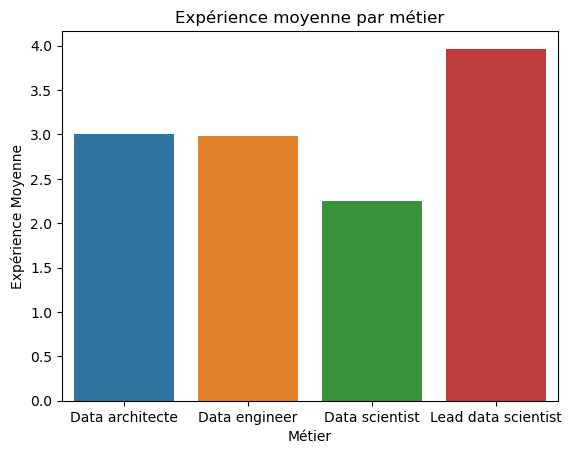

In [17]:
# Création d'un graphique à barre avec Seaborn
sns.barplot(data= Moyenne_metier, x='Metier', y= 'Experience moyenne' )

# Ajout d'etiquettes et de titre
plt.title('Expérience moyenne par métier')
plt.ylabel('Expérience Moyenne')
plt.xlabel('Métier')

# Afficher le graphique
plt.show()

Parmi les candidats, les Lead Data scientist ont en moyenne plus d'experience que les autres candidats. Par contre les Data Scientist ont en moyenne moins d'expérience par rapport aux autres candidats. 

#### 4-2 Catégorisation de la Variable Experience

Pour categoriser la variable "Experience", nous représenterons un histogramme de cette variable numérique pour visualiser sa distribution naturelle. En analysant le graphique,  nous serons en mésure de définir les différentes bornes de classes à utiliser pour regrouper les valeurs d'experience. Cette approche nous permettra d'obtenir des catégories sigificatives et adaptées à la répartition des données. 

In [18]:
df.describe()

,Experience
count,9540.000000
mean,2.812479
std,2.709135
min,0.000000
25%,1.000000
50%,2.000000
75%,3.500000
max,21.000000


In [19]:
df.isna().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      42
Ville            0
dtype: int64

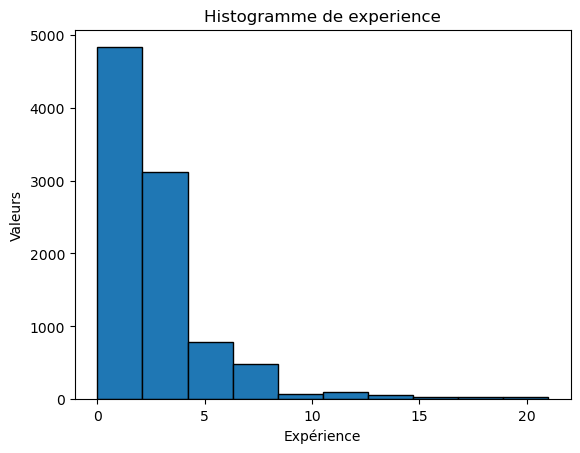

In [20]:
# Tracer l'histogramme de la variable 'Experience'
plt.hist(df['Experience'], edgecolor='black')

# Ajout d'etiquettes et de titre
plt.xlabel('Expérience')
plt.ylabel('Valeurs')
plt.title('Histogramme de experience')

# Afficher le graphique
plt.show()

A partir de ce graphique, on dénote suivant la représentation 4 bornes supérieures à savoir : 2, 4, 8 et 22.

In [21]:
# Création de catégories d'expérience
bins = [0, 2, 4, 8, 22]
labels = ["Débutant", "Confirmé", "Avancé", "Expert"]
df['categorie_exp'] = pd.cut(df['Experience'], bins=bins, labels=labels, right=False)
df[['categorie_exp']]

,categorie_exp
0,Débutant
1,Confirmé
2,Confirmé
3,Débutant
4,Confirmé
...,...
9577,Débutant
9578,Expert
9579,Débutant
9580,Expert


In [22]:
df['categorie_exp'].unique()

['Débutant', 'Confirmé', 'Avancé', 'Expert', NaN]
Categories (4, object): ['Débutant' < 'Confirmé' < 'Avancé' < 'Expert']

#### 4-3 Analyse comparative du métier selon la catégorie d'experience

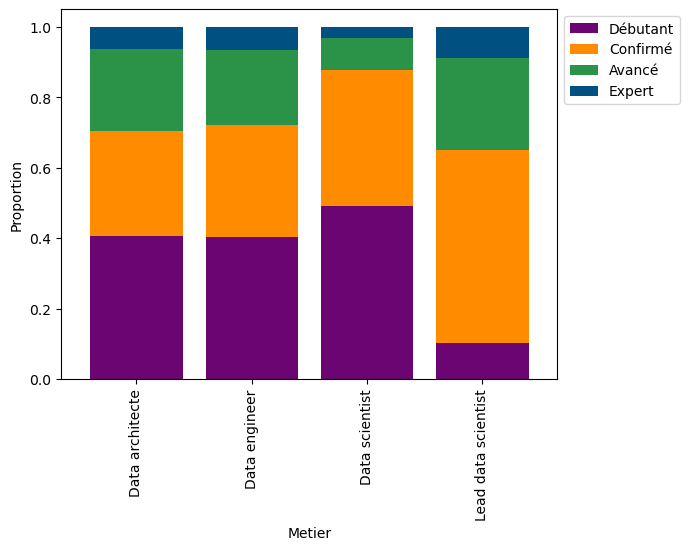

In [23]:
cross_tab_prop_cexp = pd.crosstab(index=df['Metier'], columns=df['categorie_exp'], normalize='index')

# Définir une liste de quatre couleurs qui vont bien ensemble
colors = ['#6a0572', '#ff8c00', '#2b9348', '#005082']

# Créer une colormap à partir de la liste de couleurs
custom_cmap = ListedColormap(colors)

ax = cross_tab_prop_cexp.plot(kind='bar', stacked=True, width=0.8,  cmap= custom_cmap,
                        legend=False, ylabel='Proportion', sharey=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))

    

#### 4-4 Identification du top 5 des technologies

La variable Technologie contient des valeurs de la forme Technologie1/Technologie2/ .... Il est donc nécessaire, avant toute chose, de récuperer chaque Technologie par du split de manière séquencée. Par la suite on pourra compter le nombre d'occurence de chaque technologie. 

Il est necessaire de prétraiter la variable "Technologie" qui contient des valeurs sous la forme de chaines de caractères avec des technologies multiples séparées par des slashes (par exemple SPSS/R/SAS/Stata ). Pour ce faire une étape cruciale consite à extraire chaque technologie de manière séquentielle en utilisant lopération de fractionnement (split) en fonction de /. Une fois cette opération effectuée, nous pourrons compter le nombre d'occurence de chaque technologie distincte.

In [24]:
 # Diviser la colonne Technologies en plusieurs colonnes
df_technologies = df['Technologies'].str.split('/', expand=True)

# Obtenir le nombre maximal de colonnes créées
nbre_mac_col = df_technologies.shape[1]

print("Le nombre maximal de colonnes créées est : ", nbre_mac_col)



Le nombre maximal de colonnes créées est :  7


In [25]:
# Renommer les colonnes
df_technologies.columns = ['Technologie1', 'Technologie2', 'Technologie3', 'Technologie4', 'Technologie5', 'Technologie6', 'Technologie7']

# Ajouter les nouvelles colonnes au dataframe d'origine
df = pd.concat([df, df_technologies], axis=1)

# Afficher df
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,categorie_exp,Technologie1,Technologie2,Technologie3,Technologie4,Technologie5,Technologie6,Technologie7
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.000000,Paris,Débutant,Matlab,Python,Pyspark,Scikit-learn,Tensorflow,None,None
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.000000,Marseille,Confirmé,Python,Java,Scala,MongoDB,None,None,None
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.000000,Nantes,Confirmé,SPSS,SQL,Teradata,R,Python,Tensorflow,scikit-learn
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.500000,Marseille,Débutant,C,C++,Java,Python,None,None,None
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.814186,Bordeaux,Confirmé,Matlab,Python,C++,numpy,Tensorflow,scikit-learn,None


In [26]:
df.shape

(9582, 14)

In [27]:
# Obtenez les valeurs uniques en utilisant stack() et unique()
unique_technologies = df_technologies.stack().unique()

print("Valeurs uniques de technologies :", unique_technologies)

Valeurs uniques de technologies : ['Matlab' 'Python' 'Pyspark' 'Scikit-learn' 'Tensorflow' 'Java' 'Scala'
 'MongoDB' 'SPSS' 'SQL' 'Teradata' 'R' 'scikit-learn' 'C' 'C++' 'numpy'
 'VBA' 'Excel' 'PySpark' 'Linux' 'Docker' 'GNU' 'Hadoop' 'Hive' 'MariaDB'
 'machine learning' 'Spark' 'AWS' 'Deep learning' 'PostgreSQL'
 'Elasticsearch' 'Kibana' 'HDFS' 'Yarn' 'Microsoft Azure' 'Redshift' 'SAS'
 'Machine learning' 'Anglais' 'anglais' 'AI' 'Scoring' 'Perl' 'Ruby'
 'Pycharm' 'Vertica' 'Tableau' '' 'Big data' 'Kafka' 'ORACLE' 'MySQL'
 'Cassandra' 'NoSQL' 'Matplotlib' 'Map-Reduce' 'PIG' 'HBASE' 'Windows'
 'NoSQ' 'Hadoop(HDFS)']


In [28]:
# Empiler les colonnes pour obtenir une série
df_unique_technologies = df_technologies.stack()


# Compter les occurrences de chaque technologie
df_counts = df_unique_technologies.value_counts().reset_index()
df_counts.columns = ['Technologies', 'Occurence']

# Trier le DataFrame par compte décroissant
df_counts_sorted = df_counts.sort_values(by='Occurence', ascending= False)


# Ajouter une nouvelle colonne avec le nombre d'occurrences normalisé
df_counts_sorted['Occurence Normalisée'] = df_counts_sorted['Occurence'] / df.shape[0]
df_counts_sorted['Occurence Normalisée']= df_counts_sorted['Occurence Normalisée'].map(lambda x: '{:.2%}'.format(x))

top_5_technologies = df_counts_sorted.head(5)

# Afficher le top 5 des technologies
top_5_technologies



,Technologies,Occurence,Occurence Normalisée
0,Python,6627,69.16%
1,R,4374,45.65%
2,SQL,2581,26.94%
3,Java,1719,17.94%
4,Hadoop,1589,16.58%


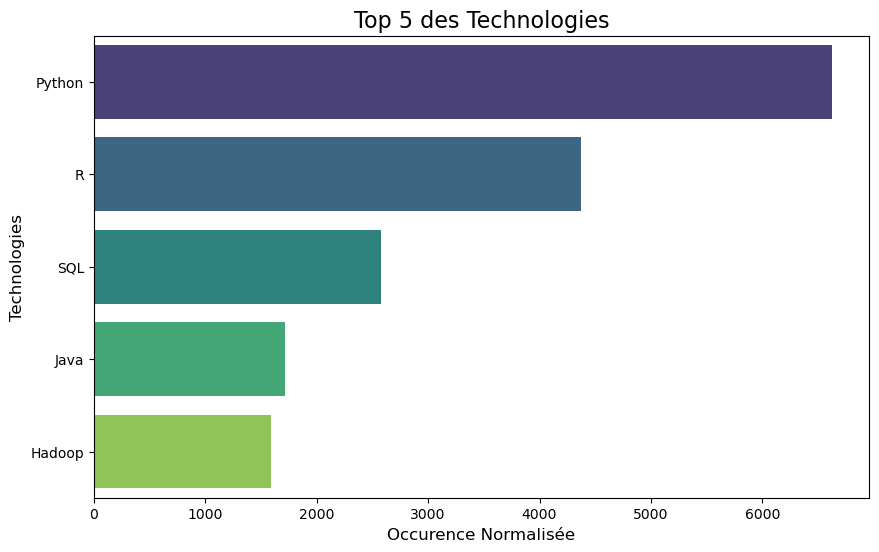

In [29]:

# Créer un barplot avec Seaborn
plt.figure(figsize=(10, 6))
barplot= sns.barplot(x='Occurence', y='Technologies', data=top_5_technologies, palette='viridis')


# Ajouter un titre et des étiquettes aux axes
plt.title('Top 5 des Technologies', fontsize=16)
plt.xlabel('Occurence Normalisée', fontsize=12)
plt.ylabel('Technologies', fontsize=12)

# Afficher le graphique
plt.show()


In [30]:
df.columns

Index(['Entreprise', 'Metier', 'Technologies', 'Diplome', 'Experience',
       'Ville', 'categorie_exp', 'Technologie1', 'Technologie2',
       'Technologie3', 'Technologie4', 'Technologie5', 'Technologie6',
       'Technologie7'],
      dtype='object')

In [31]:
# Compter le nombre de valeurs uniques pour chaque feature sélectionnée
features = ['Entreprise', 'Metier', 'Technologies', 'Diplome', 'categorie_exp',
       'Ville']

for f in features: 
    print (f"Nombre de valeurs uniques pour {f} :")
    print (df[f].nunique())


Nombre de valeurs uniques pour Entreprise :
1382
Nombre de valeurs uniques pour Metier :
4
Nombre de valeurs uniques pour Technologies :
57
Nombre de valeurs uniques pour Diplome :
4
Nombre de valeurs uniques pour categorie_exp :
4
Nombre de valeurs uniques pour Ville :
14


In [32]:
# Liste des technologies à rechercher
technologies_to_search = ['Python', 'R', 'SQL', 'Java', 'Hadoop']

# Pour chaque technologie, créer une nouvelle colonne indiquant la présence (1) ou l'absence (0)
for tech in technologies_to_search:
    df[f'{tech}_present'] = df.apply(lambda row: 1 if tech in row['Technologies'] else 0, axis=1)

# Afficher le DataFrame mis à jour
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,categorie_exp,Technologie1,Technologie2,Technologie3,Technologie4,Technologie5,Technologie6,Technologie7,Python_present,R_present,SQL_present,Java_present,Hadoop_present
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.000000,Paris,Débutant,Matlab,Python,Pyspark,Scikit-learn,Tensorflow,None,None,1,0,0,0,0
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.000000,Marseille,Confirmé,Python,Java,Scala,MongoDB,None,None,None,1,0,0,1,0
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.000000,Nantes,Confirmé,SPSS,SQL,Teradata,R,Python,Tensorflow,scikit-learn,1,1,1,0,0
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.500000,Marseille,Débutant,C,C++,Java,Python,None,None,None,1,0,0,1,0
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.814186,Bordeaux,Confirmé,Matlab,Python,C++,numpy,Tensorflow,scikit-learn,None,1,0,0,0,0


In [33]:
df.columns

Index(['Entreprise', 'Metier', 'Technologies', 'Diplome', 'Experience',
       'Ville', 'categorie_exp', 'Technologie1', 'Technologie2',
       'Technologie3', 'Technologie4', 'Technologie5', 'Technologie6',
       'Technologie7', 'Python_present', 'R_present', 'SQL_present',
       'Java_present', 'Hadoop_present'],
      dtype='object')

In [34]:
df.shape

(9582, 19)

In [35]:
# Liste des noms des variables explicatives qualitatives
qualitative_explanatory_variables = ['Entreprise', 'Diplome','categorie_exp',
       'Ville', 'Python_present', 'R_present', 'SQL_present',
       'Java_present', 'Hadoop_present']



# Réglages de la grille
sns.set(style="whitegrid")

for exp_var in qualitative_explanatory_variables:
    # Créer une table de contingence
    contingency_table = pd.crosstab(index=df[exp_var], columns=df['Metier'])
    
    # Effectuer le test du chi2
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Imprimer les résultats du test du chi2
    print(f"\nTest du Chi2 pour {exp_var} par rapport à Metier:")
    print(f"Statistique Chi2 : {chi2_stat}, p-value : {p_value}")


Test du Chi2 pour Entreprise par rapport à Metier:
Statistique Chi2 : 3142.9509866107737, p-value : 1.0

Test du Chi2 pour Diplome par rapport à Metier:
Statistique Chi2 : 1372.2354582667012, p-value : 7.705931060468917e-290

Test du Chi2 pour categorie_exp par rapport à Metier:
Statistique Chi2 : 847.5008630038014, p-value : 1.2599711433186386e-176

Test du Chi2 pour Ville par rapport à Metier:
Statistique Chi2 : 52.936264599013484, p-value : 0.0674478699453858

Test du Chi2 pour Python_present par rapport à Metier:
Statistique Chi2 : 1567.262925693883, p-value : 0.0

Test du Chi2 pour R_present par rapport à Metier:
Statistique Chi2 : 5609.953178250393, p-value : 0.0

Test du Chi2 pour SQL_present par rapport à Metier:
Statistique Chi2 : 773.9955870341221, p-value : 1.887396278362818e-167

Test du Chi2 pour Java_present par rapport à Metier:
Statistique Chi2 : 1222.6851499307945, p-value : 8.774962776033679e-265

Test du Chi2 pour Hadoop_present par rapport à Metier:
Statistique Chi

La variable "Entreprise" n'a aucune relation significative avec notre variable d'interet. La variable "Ville" ne définit pas non plus le métier du candidat. Par contre le métier de l'individu dépend de s'il maitrise Python et R surtout puis également de son diplome.

In [36]:
# Encoder les variables catégorielles avec plus de deux modalités avec OneHot Encoding
from sklearn.preprocessing import OneHotEncoder


# Initialiser l'encodeur
encoder = OneHotEncoder(sparse=False)

# Adapter et transformer les données
df_encoded = pd.DataFrame(encoder.fit_transform(df[['categorie_exp','Ville','Diplome']]), columns=encoder.get_feature_names_out(['categorie_exp','Ville','Diplome']))

# Ajouter les colonnes encodées au dataframe d'origine
df = pd.concat([df, df_encoded], axis=1)

df.head()

print (df.shape)

(9582, 42)


D:\Programme\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
df = df.dropna(subset=['Experience'])
df.shape

(9540, 42)

In [38]:
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,categorie_exp,Technologie1,Technologie2,Technologie3,...,Ville_Paris,Ville_Rennes,Ville_Rouen,Ville_Strasbourg,Ville_Toulon,Ville_Toulouse,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.000000,Paris,Débutant,Matlab,Python,Pyspark,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.000000,Marseille,Confirmé,Python,Java,Scala,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.000000,Nantes,Confirmé,SPSS,SQL,Teradata,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.500000,Marseille,Débutant,C,C++,Java,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.814186,Bordeaux,Confirmé,Matlab,Python,C++,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 5- Clustering : classification non supervisée

In [39]:
cluster_data = df.drop(columns= 'Metier')
cluster_data.head()
print(cluster_data.shape)

(9540, 41)


In [40]:
cluster_data_copy = cluster_data.copy()

In [41]:
cluster_data = cluster_data[['categorie_exp','Diplome','Ville','Python_present', 'R_present', 'SQL_present', 'Java_present', 'Hadoop_present']]
cluster_data.head()

,categorie_exp,Diplome,Ville,Python_present,R_present,SQL_present,Java_present,Hadoop_present
0,Débutant,Master,Paris,1,0,0,0,0
1,Confirmé,Master,Marseille,1,0,0,1,0
2,Confirmé,Master,Nantes,1,1,1,0,0
3,Débutant,Master,Marseille,1,0,0,1,0
4,Confirmé,Phd,Bordeaux,1,0,0,0,0


In [42]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cluster_data = cluster_data.apply(le.fit_transform)
cluster_data.head()

,categorie_exp,Diplome,Ville,Python_present,R_present,SQL_present,Java_present,Hadoop_present
0,2,1,8,1,0,0,0,0
1,1,1,4,1,0,0,1,0
2,1,1,6,1,1,1,0,0
3,2,1,4,1,0,0,1,0
4,1,3,0,1,0,0,0,0


In [43]:
cost = []
for num_clusters in list(range(1,7)):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 1, verbose=1)
    kmode.fit_predict(cluster_data)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 31925.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 103, cost: 28758.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1305, cost: 24027.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2817, cost: 22684.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2764, cost: 21785.0
Run 1, iteration: 2/100, moves: 42, cost: 21785.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2375, cost: 21870.0


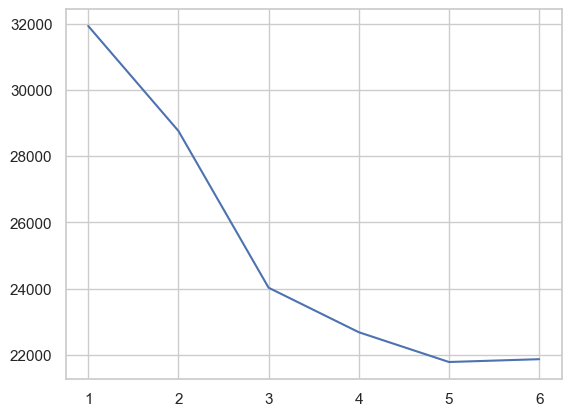

In [44]:
y = np.array([i for i in range(1,7,1)])
plt.plot(y,cost)

In [45]:
kmode_hg = KModes(n_clusters=2, init = "Huang", n_init = 1, verbose=1)
fitcluster_hg = kmode_hg.fit_predict(cluster_data)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1482, cost: 26591.0


In [46]:
cluster_data = cluster_data_copy.reset_index()
clustersDf = pd.DataFrame(fitcluster_hg)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([cluster_data, clustersDf], axis = 1).reset_index()


In [47]:
combinedDf['Metier'] = df['Metier']
combinedDf[['cluster_predicted','Metier']].head()

,cluster_predicted,Metier
0,0,Data scientist
1,0,Data architecte
2,1,Lead data scientist
3,0,Data scientist
4,0,Data scientist


In [74]:
contingency_table = pd.crosstab(index=combinedDf["cluster_predicted"], columns=combinedDf['Metier'], normalize= 'columns')
contingency_table

Metier,Data architecte,Data engineer,Data scientist,Lead data scientist
cluster_predicted,,,,
0,0.659037,0.657669,0.643675,0.655887
1,0.340963,0.342331,0.356325,0.344113


In [73]:
contingency_table = pd.crosstab(index=combinedDf["cluster_predicted"], columns=combinedDf['Diplome'], normalize= 'columns')
contingency_table

Diplome,Bachelor,Master,No diploma,Phd
cluster_predicted,,,,
0,0.66907,0.649485,0.839286,0.567436
1,0.33093,0.350515,0.160714,0.432564


In [ ]:
contingency_table = pd.crosstab(index=combinedDf["cluster_predicted"], columns=combinedDf['Diplome'], normalize= 'columns')
contingency_table

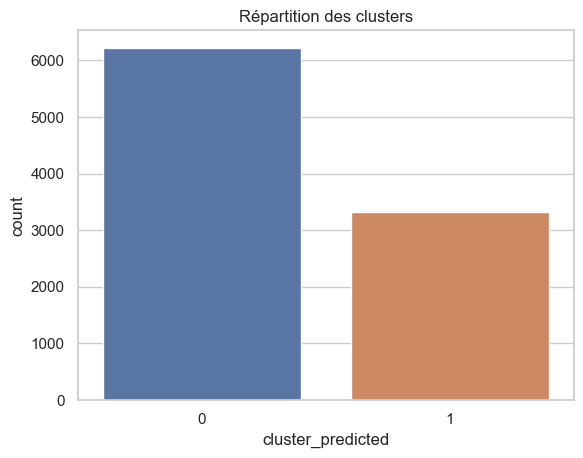

In [75]:
# Visualisation des clusters
sns.countplot(x='cluster_predicted', data=combinedDf)
plt.title('Répartition des clusters')
plt.show()



## 6- Prediction des metiers manquants dans la base de données par Random Forest

#### 6-1 Construction du modèle

In [49]:
# Filtrez les NaN dans 'Metier'
data = df.dropna(subset=['Metier'])
data.shape


(9521, 42)

In [50]:
# Nombre de valeurs manquantes par variables
data.isna().sum()

Entreprise                  17
Metier                       0
Technologies                 0
Diplome                      0
Experience                   0
Ville                        0
categorie_exp                0
Technologie1                 0
Technologie2                 0
Technologie3               220
Technologie4              1610
Technologie5              4988
Technologie6              7692
Technologie7              8713
Python_present               0
R_present                    0
SQL_present                  0
Java_present                 0
Hadoop_present               0
categorie_exp_Avancé         0
categorie_exp_Confirmé       0
categorie_exp_Débutant       0
categorie_exp_Expert         0
categorie_exp_nan            0
Ville_Bordeaux               0
Ville_Grenoble               0
Ville_Lille                  0
Ville_Lyon                   0
Ville_Marseille              0
Ville_Montpellier            0
Ville_Nantes                 0
Ville_Nice                   0
Ville_Pa

In [51]:
# Supprimer des variables qui ne compteront pas dans le modèle
data.drop ( columns = ['categorie_exp_nan','categorie_exp','Ville','Diplome', 'Entreprise','Technologies','Experience', 'Technologie1', 'Technologie2', 'Technologie3', 'Technologie4', 'Technologie5', 'Technologie6', 'Technologie7'], inplace = True)

C:\Users\VODOUMBO Miracle\AppData\Local\Temp\ipykernel_20596\2331781406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop ( columns = ['categorie_exp_nan','categorie_exp','Ville','Diplome', 'Entreprise','Technologies','Experience', 'Technologie1', 'Technologie2', 'Technologie3', 'Technologie4', 'Technologie5', 'Technologie6', 'Technologie7'], inplace = True)


In [52]:
# Encoder les variables catégorielles binaires avec LabelEncoder
label_encoder = LabelEncoder()
data['Metier'] = label_encoder.fit_transform(data['Metier'])
data.head()

C:\Users\VODOUMBO Miracle\AppData\Local\Temp\ipykernel_20596\279696386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Metier'] = label_encoder.fit_transform(data['Metier'])


,Metier,Python_present,R_present,SQL_present,Java_present,Hadoop_present,categorie_exp_Avancé,categorie_exp_Confirmé,categorie_exp_Débutant,categorie_exp_Expert,...,Ville_Paris,Ville_Rennes,Ville_Rouen,Ville_Strasbourg,Ville_Toulon,Ville_Toulouse,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd
0,2,1,0,0,0,0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,1,0,0,1,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,1,1,0,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2,1,0,0,1,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,1,0,0,0,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
# Avoir les différentes correspondances
correspondances = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(correspondances)

{'Data architecte': 0, 'Data engineer': 1, 'Data scientist': 2, 'Lead data scientist': 3}


In [54]:
#Valeurs manquantes
data.isna().sum()

Metier                    0
Python_present            0
R_present                 0
SQL_present               0
Java_present              0
Hadoop_present            0
categorie_exp_Avancé      0
categorie_exp_Confirmé    0
categorie_exp_Débutant    0
categorie_exp_Expert      0
Ville_Bordeaux            0
Ville_Grenoble            0
Ville_Lille               0
Ville_Lyon                0
Ville_Marseille           0
Ville_Montpellier         0
Ville_Nantes              0
Ville_Nice                0
Ville_Paris               0
Ville_Rennes              0
Ville_Rouen               0
Ville_Strasbourg          0
Ville_Toulon              0
Ville_Toulouse            0
Diplome_Bachelor          0
Diplome_Master            0
Diplome_No diploma        0
Diplome_Phd               0
dtype: int64

In [55]:
# types des variables
data.dtypes

Metier                      int32
Python_present              int64
R_present                   int64
SQL_present                 int64
Java_present                int64
Hadoop_present              int64
categorie_exp_Avancé      float64
categorie_exp_Confirmé    float64
categorie_exp_Débutant    float64
categorie_exp_Expert      float64
Ville_Bordeaux            float64
Ville_Grenoble            float64
Ville_Lille               float64
Ville_Lyon                float64
Ville_Marseille           float64
Ville_Montpellier         float64
Ville_Nantes              float64
Ville_Nice                float64
Ville_Paris               float64
Ville_Rennes              float64
Ville_Rouen               float64
Ville_Strasbourg          float64
Ville_Toulon              float64
Ville_Toulouse            float64
Diplome_Bachelor          float64
Diplome_Master            float64
Diplome_No diploma        float64
Diplome_Phd               float64
dtype: object

In [56]:
# Selectionner les colonnes pertinentes pour les caracteristiques
X = data.drop(columns = 'Metier')

y = data['Metier']

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
# Dimensions de X_train et X_test
print ('The shape of X_train is: ', X_train.shape)
print ('The shape of X_test is: ', X_test.shape)


The shape of X_train is:  (7616, 27)
The shape of X_test is:  (1905, 27)


In [58]:
# Optimisation des hyperparamètres
rf_params = {
        'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 110, num = 11)],
            'max_depth': [int(x) for x in np.linspace(4, 20, num = 3)],
            'bootstrap': [True, False]
        }  
    }
}

scores = []

for model_name, mp in rf_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Affichage des valeurs optimales des hypers-paramètres
scores

[{'model': 'random_forest',
  'best_score': 0.684612322343489,
  'best_params': {'bootstrap': True, 'max_depth': 12, 'n_estimators': 30}}]

In [59]:
# Accéder au dictionnaire dans la liste

best_params_dict = scores[0]['best_params']

# Extraire les valeurs spécifiques
bootstrap_value = best_params_dict['bootstrap']
max_depth_value = best_params_dict['max_depth']
n_estimators_value = best_params_dict['n_estimators']

In [60]:
# Initialisez le classificateur RandomForest
RFclassifier = RandomForestClassifier(bootstrap= bootstrap_value, max_depth= max_depth_value, n_estimators= n_estimators_value)

#### 6-2 Evaluation du modèle

Text(47.25, 0.5, 'Classes réelles')

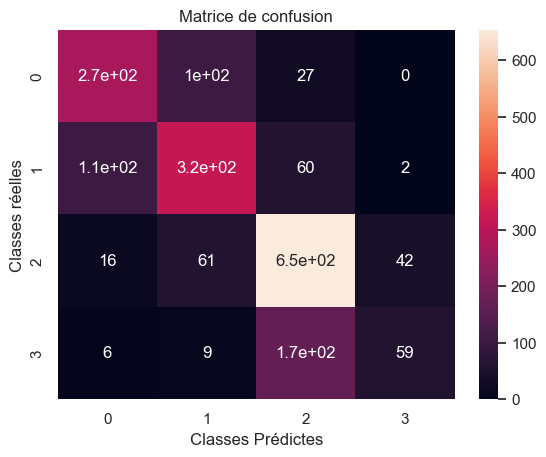

In [61]:
# Afficher la matrice de confusion
RFclassifier.fit(X_train, y_train)

y_pred = RFclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True)
ax.set_title("Matrice de confusion")
ax.set_xlabel('Classes Prédictes')
ax.set_ylabel('Classes réelles')

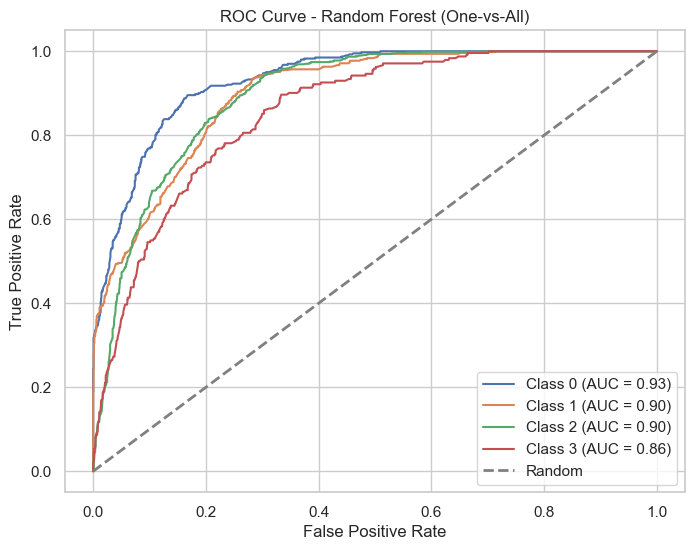

In [62]:
# Utilisez OneVsRestClassifier pour créer un classificateur pour chaque classe
classifier = OneVsRestClassifier(RFclassifier)

# Binarisez vos étiquettes
y_train_bin = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_bin= label_binarize(y_test, classes=[0, 1, 2, 3])

# Entraînez le modèle
classifier.fit(X_train, y_train_bin)

# Obtenez les scores des prédictions pour chaque classe
y_scores = classifier.predict_proba(X_test)

# Calculez la courbe ROC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracez la courbe ROC pour chaque classe
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (One-vs-All)')
plt.legend()
plt.show()


#### 6-3 Prediction des Metiers manquants

In [63]:
# Base de données des observations avec valeurs manquantes pour la variable Metier 
data_pred = df.loc[df['Metier'].isna()]
data_pred.shape

(19, 42)

In [64]:
#Preprocessing
data_pred.drop ( columns = ['categorie_exp_nan','categorie_exp','Ville','Diplome','Entreprise',
                            'Technologies','Experience', 'Technologie1', 'Technologie2', 'Technologie3', 'Technologie4', 'Technologie5', 'Technologie6', 'Technologie7'], inplace = True)
data_pred.head()

C:\Users\VODOUMBO Miracle\AppData\Local\Temp\ipykernel_20596\4072062943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred.drop ( columns = ['categorie_exp_nan','categorie_exp','Ville','Diplome','Entreprise',


,Metier,Python_present,R_present,SQL_present,Java_present,Hadoop_present,categorie_exp_Avancé,categorie_exp_Confirmé,categorie_exp_Débutant,categorie_exp_Expert,...,Ville_Paris,Ville_Rennes,Ville_Rouen,Ville_Strasbourg,Ville_Toulon,Ville_Toulouse,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd
346,NaN,1,0,0,0,0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2058,NaN,1,1,0,0,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2670,NaN,1,1,0,1,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2899,NaN,1,1,0,0,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3346,NaN,0,0,1,0,0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [65]:
# Suppression de la colonne Metier constitué que des valeurs manquantes à prédire
data_pred.drop ( columns = 'Metier', inplace = True)
data_pred.head()

C:\Users\VODOUMBO Miracle\AppData\Local\Temp\ipykernel_20596\2971957982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred.drop ( columns = 'Metier', inplace = True)


,Python_present,R_present,SQL_present,Java_present,Hadoop_present,categorie_exp_Avancé,categorie_exp_Confirmé,categorie_exp_Débutant,categorie_exp_Expert,Ville_Bordeaux,...,Ville_Paris,Ville_Rennes,Ville_Rouen,Ville_Strasbourg,Ville_Toulon,Ville_Toulouse,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd
346,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2058,1,1,0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2670,1,1,0,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2899,1,1,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3346,0,0,1,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [66]:
# Prediction effectuée avec le modèle initalisé de base
Metier_predict = RFclassifier.predict(data_pred)
Metier_predict

array([1, 2, 2, 2, 0, 2, 2, 3, 1, 2, 0, 1, 0, 2, 2, 2, 0, 2, 3])

In [67]:
# Dictionnaire de correspondance
label_dict = {0: 'Data Architect', 1: 'Data Engineer', 2: 'Data Scientist', 3: 'Lead Data Scientist'}

# Appliquer la correspondance avec une liste de compréhension
Metier_predict = [label_dict[label] for label in Metier_predict]

Metier_predict

['Data Engineer',
 'Data Scientist',
 'Data Scientist',
 'Data Scientist',
 'Data Architect',
 'Data Scientist',
 'Data Scientist',
 'Lead Data Scientist',
 'Data Engineer',
 'Data Scientist',
 'Data Architect',
 'Data Engineer',
 'Data Architect',
 'Data Scientist',
 'Data Scientist',
 'Data Scientist',
 'Data Architect',
 'Data Scientist',
 'Lead Data Scientist']

In [68]:
data_pred['Metier_predicted']= Metier_predict
data_pred

C:\Users\VODOUMBO Miracle\AppData\Local\Temp\ipykernel_20596\3290272202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred['Metier_predicted']= Metier_predict


,Python_present,R_present,SQL_present,Java_present,Hadoop_present,categorie_exp_Avancé,categorie_exp_Confirmé,categorie_exp_Débutant,categorie_exp_Expert,Ville_Bordeaux,...,Ville_Rennes,Ville_Rouen,Ville_Strasbourg,Ville_Toulon,Ville_Toulouse,Diplome_Bachelor,Diplome_Master,Diplome_No diploma,Diplome_Phd,Metier_predicted
346,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Data Engineer
2058,1,1,0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Data Scientist
2670,1,1,0,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,Data Scientist
2899,1,1,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Data Scientist
3346,0,0,1,0,0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Data Architect
4248,1,1,1,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Data Scientist
4290,1,1,1,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,Data Scientist
4292,1,1,1,0,0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Lead Data Scientist
5425,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Data Engineer
5593,1,1,0,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Data Scientist



<hr>


| Date              | Auteur           |
| ----------------- | ---------------- | 
| 05-11-2023        | Miracle VODOUMBO | 


<p>

